Nous allons nous attacher à l'étude fait de la première Database que nous avons obtenue. Initialement prévue pour récupérer les données d'une playlist de 10000 sons, nous avons fait face à des erreurs dues à un trop grand nombre de requêtes. Nous nous sommes ensuite rendus compte, grâce à l'étude de la première base de données partielle obtenues, que l'apporche d'une grande playlist compilant de nombreux moreceaux n'était pas la meilleure. Ce qui suit décrit cette première étude.

# Première approche

## Obtention des données

Importons d'abord les modules nécessaires:

In [167]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import csv
import time


On initialise le client spotify pour l'obtention des données via l'API

In [168]:
def spotify_client():
    """
    Initialize the Spotify API client with client credentials.
    Returns an authenticated Spotify client.
    """
    return spotipy.Spotify(auth_manager=SpotifyClientCredentials(
        client_id="d666ee3ae4c94b85945c3dba39776f4f",
        client_secret="c1973a77acbe48c0b2f105e4f57d7d46" 
    ))

Notre objectif final est d'obtenir un fichier csv compilant toutes les données fournies par l'API de Spotify dans un fichier csv. Voici la fonction réalisant cette tache

In [169]:
def get_playlists_data_to_csv(playlist_ids):
    """This function allows to fetch the data from different playlists into a csv 
    Params:
        - playlist_ids: a list of playlists we want to fetch our data from
    """
    names=[]
    track_data=[]
    file_name=''
    for playlist in playlist_ids: 
        print(f"Fetching playlist {playlist} tracks...")
        tracks = fetch_playlist_tracks(playlist)
        print("Fetching track data...")
        track_data+=(fetch_track_data(tracks))
    for id in playlist_ids:
        names.append(spotify_client().playlist(id)['name'])
    for name in names:
        file_name+=name+'+'
    file_name=file_name[:-1]
    print(file_name)
    if track_data:
        save_to_csv(track_data, f"playlists_{file_name}_data.csv")
    else:
        print("No data to save.")

Détaillons cette fonction, la fonction fetch_playlist_tracks est définie ci-dessous, elle permet l'obtention d'informations identifiant l'ensemble des musiques d'une playlist

In [170]:
def fetch_playlist_tracks(playlist_id):
    """
    Fetch all tracks from a Spotify playlist. 
    Params:
        -playlist_id: Spotify playlist ID.
    Returns a list of dictionaries containing track details.
    """
    tracks = []
    results = spotify_client().playlist_tracks(playlist_id)
    while results:
        for item in results['items']:
            track = item['track']
            if track:  # Ensure the track is not None
                tracks.append(track)
        results = spotify_client().next(results) if results['next'] else None
    return tracks

Il faut également obtenir le genre de l'artiste que nous assimilerons dans un premier temps à celui de la musique.

In [171]:
def fetch_artist_genre(track):
    """This function fetches the genre of an artist with a track from this artist, it will be 
    considerated as the genre of the song later

    Args:
        track a dict the countains infos about the track

    Returns: genre a string that is the genre of an artist
        
    """
    artist=track['artists'][0]['id']
    if spotify_client().artist(artist)['genres'] != []:
        return spotify_client().artist(artist)['genres'][0]
    else:
        return 'N/A'

On peut alors obtenir l'ensemble des informations relatives à chaque musique utiles à l'analyse (dansabilité, tempo...) via la fonction fetch_track_data. Du fait des restrictions de requêtes imposées par l'API de spotify, nous avons mis en place des requêtes par paquets de 100 chansons suivi d'une pause d'une minute, cette approche nous a permis de constituer une première base de données de 1500 musiques, en répétant ce procédé sur une plus longue période, il serait possible d'obtenir les données de l'ensemble de la playlist mais comme nous le détaillerons plus tard, nous n'avons pas retenu cette approche et nous contenterons de la base de données intermédiaire.

In [172]:
def fetch_track_data(tracks):
    """
    Fetch metadata and audio features for each track in the playlist.
    Params:
        -tracks: List of tracks from the playlist.
    Returns a list of dictionaries containing track metadata and audio features.
    """
    track_data = []
    i=0
    j=0
    for track in tracks:
        track_id = track['id']
        i+=1
        print(i)
        audio_features = spotify_client().audio_features([track_id])[0]
        genre=fetch_artist_genre(track)
        if audio_features:  # Ensure audio features are available
            artist_name = ", ".join([artist['name'] for artist in track['artists']])
            dict_track={"track Name": track['name'],
                "artists": artist_name,
                "track_id": track_id,
                "popularity": track['popularity'],
                "duration_ms": track['duration_ms'],
                "explicit": track['explicit'], 'genre': genre}
            for key in audio_features.keys():
                dict_track[key]=audio_features[key]
            track_data.append(dict_track)
        if i==100:
            j+=1
            save_to_csv(track_data, f"intermédiaire{j}")
            i=0
            time.sleep(60)
    return track_data

Il ne reste plus qu'à sauvegarder le tout au format csv: 

In [173]:
def save_to_csv(data, filename):
    """
    Save the list of track data to a CSV file.
    Params:
    :param data: List of dictionaries containing track details.
    :param filename: Output CSV file name.
    """
    keys = data[0].keys() if data else []
    with open(filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=keys)
        writer.writeheader()
        writer.writerows(data)
    print(f"Data saved to {filename}")


## Nettoyage et visualisation de la base de données

# Nettoyage

Importation des modules nécessaires

In [174]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

Ouverture de la base de données sous forme de Dataset et suppression de première colonnes inutiles (principalement des urls et popularity qui est indiquée comme n'étant que peu mise à jour)

In [175]:
df=pd.read_csv('intermédiaire3.csv')

In [176]:
df=df.drop(['track Name','track_id','type','id','uri','track_href', 'analysis_url',
       'popularity'],axis=1)

df

,artists,duration_ms,explicit,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Bob Dylan,369600,False,classic rock,0.482,0.721,0,-6.839,1,0.0321,0.731000,0.000000,0.1890,0.557,95.263,4
1,Nirvana,300977,False,grunge,0.485,0.863,1,-9.027,1,0.0495,0.000012,0.016200,0.1380,0.767,116.835,4
2,The Beatles,337413,False,british invasion,0.364,0.457,4,-14.162,0,0.0675,0.290000,0.000106,0.9220,0.175,163.219,4
3,The Beach Boys,219147,False,baroque pop,0.398,0.413,1,-10.934,1,0.0388,0.082200,0.000025,0.0891,0.331,133.574,4
4,Chuck Berry,160893,False,blues,0.518,0.756,10,-10.851,1,0.0915,0.735000,0.000062,0.3170,0.968,166.429,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,Dale Hawkins,136733,False,rock-and-roll,0.440,0.695,9,-6.164,1,0.0550,0.179000,0.001700,0.2910,0.822,142.342,4
1496,Björk,282667,False,alternative rock,0.297,0.375,1,-12.468,1,0.0434,0.032200,0.010100,0.0577,0.786,68.100,4
1497,Santana,256933,False,blues rock,0.736,0.379,7,-13.208,1,0.0539,0.301000,0.345000,0.1040,0.948,128.399,4
1498,Junior Senior,181827,False,danish pop,0.747,0.904,9,-2.623,1,0.0803,0.046000,0.106000,0.2030,0.846,118.877,4


On va regrouper les sous-genre musicaux par grands-groupes pour faciliter l'analyse.

In [177]:
genres=df['genre'].unique().tolist()
print(genres)



['classic rock', 'grunge', 'british invasion', 'baroque pop', 'blues', 'classic soul', 'brill building pop', 'album rock', 'r&b', 'rock-and-roll', 'heartland rock', 'alternative rock', 'atl hip hop', 'escape room', 'bronx hip hop', 'adult standards', 'art rock', 'funk', 'motown', 'pop', 'acid rock', 'classic garage rock', 'dance pop', 'disco', 'madchester', 'britpop', 'downtempo', 'conscious hip hop', 'east coast hip hop', 'alternative dance', 'classic girl group', 'art pop', 'lilith', 'glam metal', 'blues rock', 'chicago rap', 'electro', 'beatlesque', 'piano rock', 'irish rock', 'europop', 'lgbtq+ hip hop', 'british soul', 'reggae', 'french shoegaze', 'country', 'big beat', 'barbadian pop', 'mellow gold', 'candy pop', 'canadian hip hop', 'classic soundtrack', 'american folk revival', 'garage rock', 'australian psych', 'afrofuturism', 'g funk', 'new romantic', 'australian dance', 'brooklyn indie', 'dusseldorf electronic', 'arkansas country', 'irish punk', 'louisiana blues', 'acoustic b

In [178]:
categories = {
    "rap": [
        'hip hop', 'rap', 'dirty south rap', 'melodic rap', 'conscious hip hop', 'alternative hip hop', 'chicago rap', 
        'bronx hip hop', 'detroit hip hop', 'gangster rap', 'canadian hip hop', 'atl hip hop', 'lgbtq+ hip hop', 'bboy', 'hip pop'
    ],
    "rock": [
        'classic rock', 'album rock', 'alternative rock', 'dance rock', 'hard rock', 'soft rock', 'irish rock', 'piano rock', 
        'australian rock', 'detroit rock', 'british blues', 'garage rock', 'classic garage rock', 'glam rock', 'art rock', 
        'alternative metal', 'folk rock', 'country rock', 'protopunk', 'space rock', 'experimental rock', 'modern rock', 
        'surf music', 'pub rock', 'new wave', 'dance-punk'
    ],
    "pop": [
        'pop', 'dance pop', 'pop rock', 'ambient pop', 'alternative pop', 'bedroom pop', 'canadian pop', 'british soul', 
        'classic country pop', 'barbadian pop', 'bubblegum pop', 'torch song', 'french shoegaze', 'new wave pop', 
        'brill building pop', 'beatlesque', 'britpop', 'art pop', 'candy pop','power pop','electropop', 'experimental pop'
    ],
    "blues": [
        'blues', 'blues rock', 'classic soul', 'r&b', 'british blues', 
        'louisiana blues', 'acoustic blues'
    ],
    "jazz":['cool jazz', 'bebop', 
        'avant-garde jazz', 'big band', 'hot jazz', 'jazz blues', 'gospel', 'soul jazz'],
    "country": [
        'folk', 'american folk revival', 'appalachian folk', 'ambient folk', 'bluegrass', 'bluegrass gospel', 'celtic punk', 
        'country', 'country rock', 'bakersfield sound', 'arkansas country', 'cowboy western', 'alternative americana'
    ],
    "electro": [
        'edm', 'house', 'acid house', 'ambient', 'ambient house', 'ambient pop', 'dance-punk', 'electro', 'indietronica', 
        'balearic', 'atmospheric dnb', 'filter house', 'hi-nrg', 'big beat'
    ],
    "classical": [
        'african-american classical', 'baroque pop', 'torch song', 'classic soundtrack', 'adult standards'
    ]
}

def assign_category(genre):
    for category, keywords in categories.items():
        if genre in keywords:
            return category
        elif genre=='N/A':
            return 
    return "other"

df["category"] = df["genre"].apply(assign_category)


## Analyse univariée

Analysons tout d'abord les variables catégoriques de notre dataset:

In [179]:
categorical_var = df.copy().select_dtypes(include=["object"]).columns.to_list()
categorical_var.extend(["key","mode","time_signature","explicit"])


In [180]:
df[categorical_var].nunique()


artists           822
genre             198
category            9
key                12
mode                2
time_signature      4
explicit            2
dtype: int64

Pour les variables avec un faible nombre de valeurs différentes, nous allons les représenter sous forme d'histogramme

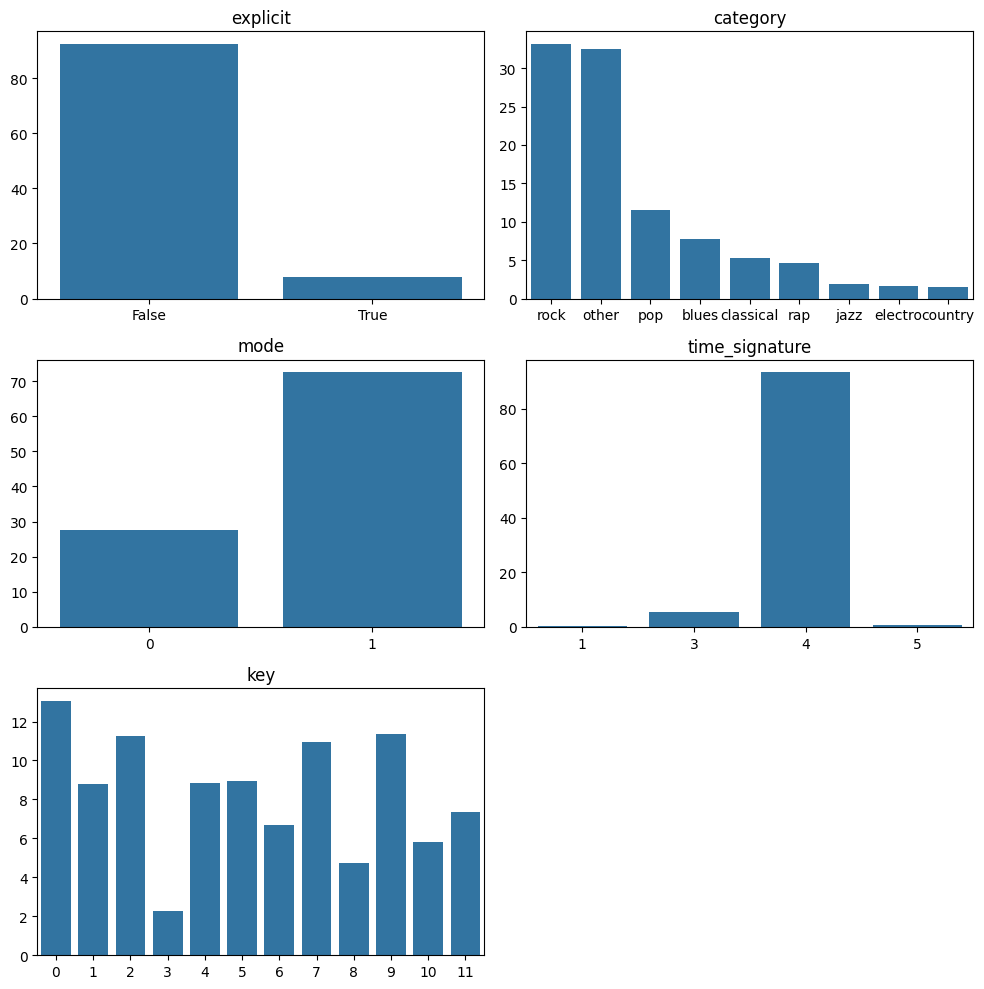

In [181]:
df_barplot = df[["explicit","category","mode","time_signature","key"]].copy()
plt.figure(figsize=(10,10))

for c,var in enumerate(df_barplot.columns):
  # compute frequency of each unique value
  df_plot= df_barplot[var].value_counts(normalize=True).to_frame("frequency").reset_index(names=var)
  df_plot["frequency"] = df_plot["frequency"]*100

  # plot the barplot
  plt.subplot(3,2,c+1)
  sns.barplot(data=df_plot, x=var, y="frequency")
  plt.title(str(var))
  plt.xlabel("")
  plt.ylabel("")

plt.tight_layout()

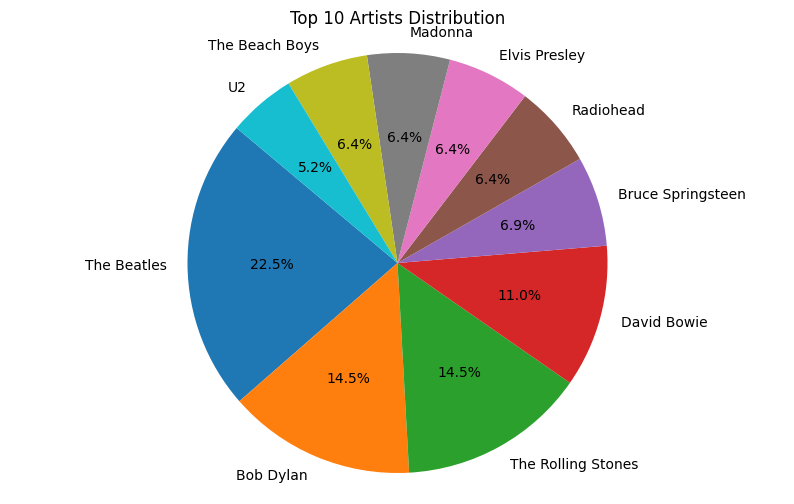

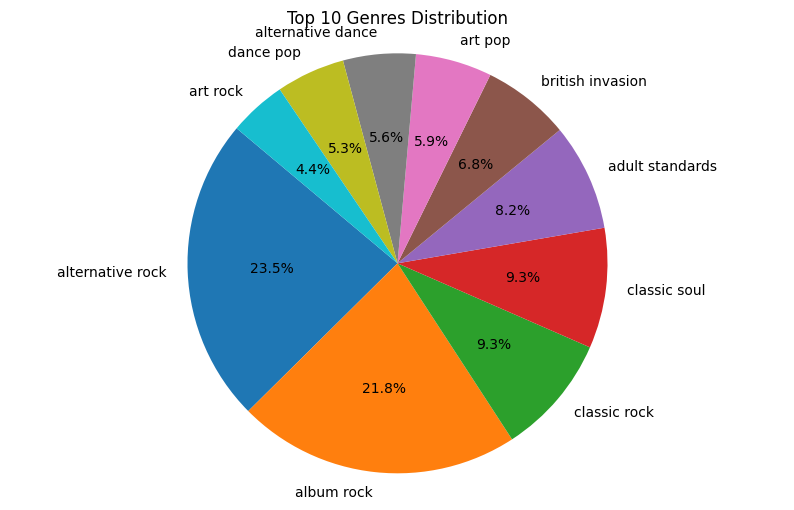

In [184]:
# Pie chart for 'artists'
artist_counts = df['artists'].value_counts().head(10)  # Get top 10 artists for better visualization
plt.figure(figsize=(10, 6))
plt.pie(artist_counts, labels=artist_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Artists Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Pie chart for 'genre'
genre_counts = df['genre'].value_counts().head(10)  # Get top 10 genres for better visualization
plt.figure(figsize=(10, 6))
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Top 10 Genres Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()